In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
display(HTML("<style>.container {width:100% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: roicat


In [2]:
from pathlib import Path
import copy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
import bnpm

QObject::moveToThread: Current thread (0x2c517b0) is not the object's thread (0x3595fb0).
Cannot move to target thread (0x2c517b0)

QObject::moveToThread: Current thread (0x2c517b0) is not the object's thread (0x3595fb0).
Cannot move to target thread (0x2c517b0)

QObject::moveToThread: Current thread (0x2c517b0) is not the object's thread (0x3595fb0).
Cannot move to target thread (0x2c517b0)

QObject::moveToThread: Current thread (0x2c517b0) is not the object's thread (0x3595fb0).
Cannot move to target thread (0x2c517b0)

QObject::moveToThread: Current thread (0x2c517b0) is not the object's thread (0x3595fb0).
Cannot move to target thread (0x2c517b0)

QObject::moveToThread: Current thread (0x2c517b0) is not the object's thread (0x3595fb0).
Cannot move to target thread (0x2c517b0)

QObject::moveToThread: Current thread (0x2c517b0) is not the object's thread (0x3595fb0).
Cannot move to target thread (0x2c517b0)

QObject::moveToThread: Current thread (0x2c517b0) is not the object's thread

In [4]:
%load_ext autoreload
%autoreload 2
import roicat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
classification_post = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403R/mouse_0403R.ROICaT.classification_drawn.results.pkl')  ## from ROICaT

In [9]:
tracking_post = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403R/stat_and_ops.ROICaT.tracking.results.pkl')  ## from ROICaT

Text(0.5, 1.0, 'sample_silhouette')

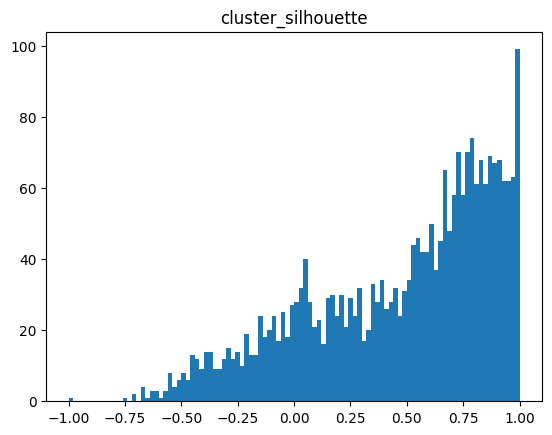

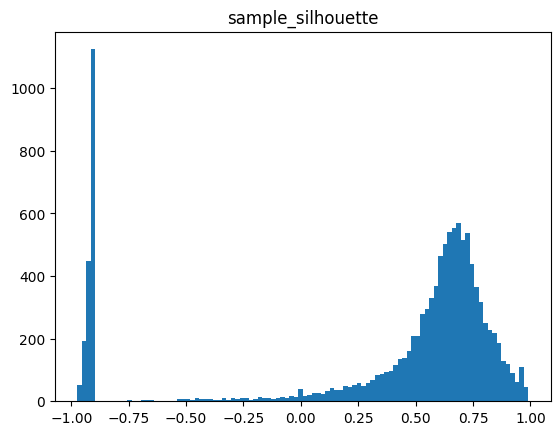

In [10]:
%matplotlib inline

plt.figure()
plt.hist(tracking_post['quality_metrics']['cluster_silhouette'], 100);
plt.title('cluster_silhouette')

plt.figure()
plt.hist(tracking_post['quality_metrics']['sample_silhouette'], 100);
plt.title('sample_silhouette')

In [11]:
dates_post = [Path(p).parts[-2] for p in tracking_post['input_data']['paths_stat']]
display(dates_post)

['20230702', '20230703', '20230706', '20230707', '20230708', '20230709']

In [14]:
paths_iscellTqm_post = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/dFoF_and_tqm/',
    reMatch='iscell_tqm.npy', 
    depth=4,
)
display(paths_iscellTqm_post)

['/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403R/dFoF_and_tqm/20230702/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403R/dFoF_and_tqm/20230703/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403R/dFoF_and_tqm/20230706/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403R/dFoF_and_tqm/20230707/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403R/dFoF_and_tqm/20230708/jobNum_0/iscell_tqm.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403R/dFoF_and_tqm/20230709/jobNum_0/iscell_tqm.npy']

In [15]:
iscell_tqm_post_raw = {Path(p).parts[-3]: np.load(p) for p in paths_iscellTqm_post}
iscell_tqm_post = [iscell_tqm_post_raw[date] for date in dates_post]

In [16]:
ucids_start = tracking_post['clusters']['labels'].copy()
ucids_unique_post = np.unique(ucids_start)
iscell_ucids_post = tracking_post['quality_metrics']['cluster_silhouette'] > -0.3
assert len(ucids_unique_post == iscell_ucids_post)

# cluster_labels_unique = tracking_post['quality_metrics']['cluster_labels_unique']
cluster_labels_unique = np.unique(tracking_post['clusters']['labels'])

ucids_badQuality_post = cluster_labels_unique[~iscell_ucids_post]

In [17]:
iscell_rois_post = tracking_post['quality_metrics']['sample_silhouette'] > 0.2

nROIs_bySession_cumsum = np.cumsum([0] + [len(l) for l in tracking_post['clusters']['labels_bySession']]).astype(np.int64)
iscell_rois_post = [tracking_post['quality_metrics']['sample_silhouette'][n:nROIs_bySession_cumsum[ii+1]] > 0.0 for ii, n in enumerate(nROIs_bySession_cumsum[:-1])]

In [18]:
def find_and_replace_values(arr, vals_find, val_replace):
    arr_out = np.array(arr, dtype=np.int64).copy()
    arr_out[np.isin(arr_out, vals_find)] = val_replace
    return arr_out

In [19]:
ucids_processed_post = [np.array(l, dtype=np.int64) for l in tracking_post['clusters']['labels_bySession']]

In [20]:
[np.place(arr=u, mask=~ic, vals=-1) for u, ic in zip(ucids_processed_post, iscell_rois_post)];

In [21]:
ucids_processed_post = [find_and_replace_values(l, vals_find=ucids_badQuality_post, val_replace=-1) for l in ucids_processed_post]

In [22]:
ucids_processed_post = roicat.util.mask_UCIDs_with_iscell(
    ucids=ucids_processed_post,
    iscell=classification_post['preds'],
)

In [23]:
ucids_processed_post = roicat.util.mask_UCIDs_with_iscell(
    ucids=ucids_processed_post,
    iscell=iscell_tqm_post,
)

In [24]:
ucids_processed_post = roicat.util.discard_UCIDs_with_fewer_matches(
    ucids=ucids_processed_post,
    n_sesh_thresh=4,
)

INFO: 50.19% of UCIDs that appear in at least 4 sessions.


In [25]:
ucids_processed_post = roicat.util.squeeze_UCID_labels(
    ucids=ucids_processed_post,
)

get dFoF

In [26]:
dFoFs = {date: np.load(Path(f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/dFoF_and_tqm/') / date / 'jobNum_0' / 'dFoF.npy', mmap_mode='r') for date in dates_post}

In [27]:
dFoFs.keys()

dict_keys(['20230702', '20230703', '20230706', '20230707', '20230708', '20230709'])

In [28]:
assert len(ucids_processed_post) == len(dFoFs)

In [29]:
dFoF_aligned = roicat.util.match_arrays_with_ucids(
    arrays=list(dFoFs.values()),
    ucids=ucids_processed_post,
    squeeze=True,
)


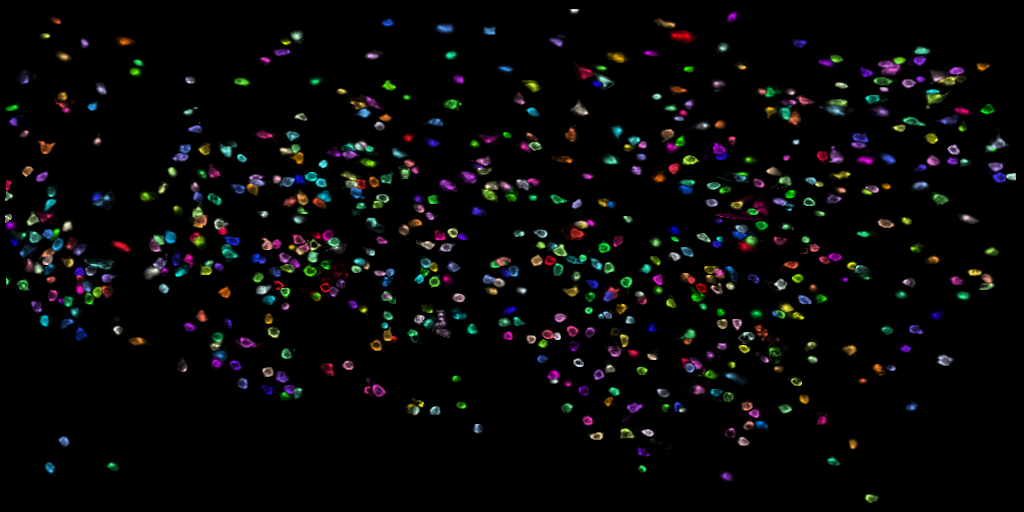

In [30]:
FOVs_colored = roicat.visualization.compute_colored_FOV(
    spatialFootprints=tracking_post['ROIs']['ROIs_aligned'],
    FOV_height=tracking_post['ROIs']['frame_height'],
    FOV_width=tracking_post['ROIs']['frame_width'],
    labels=ucids_processed_post,
)

roicat.visualization.display_toggle_image_stack(FOVs_colored,)

save aligned dF/F arrays

In [31]:
dir_save = f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/dFoF_aligned/'

In [32]:
for d, dfof in tqdm(zip(dates_post, dFoF_aligned)):
    path = str(Path(dir_save).resolve() / d / 'dFoF_aligned .npy')
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    np.save(path, dfof.astype(np.float32))

6it [00:07,  1.29s/it]


# If USING a Day 0 analysis package

### Condition 1: There exists a day 0 **classification** but no day 0 **tracking**: 

### Condition 2: There exists a day 0 **classification** AND a day 0 **tracking**: `iscell_classifier_matching_tqm.pkl`
- Generally, the UCIDs from this file will have been applied to the last day 0's dFoF to create the factor weights in the decoder definition notebook. So we need to figure out how to apply the weights to the new tracking aligned dFoF arrays. This will be done in three steps:
1. invert factor weights using the day 0 ucids
2. apply the new tracking ucids to the inverted factor weights

In [30]:
key_day0 = '20231023'
idx_day0 = dates_post.index(key_day0) 

Generally the `iscell` in this case is the union of both the day 0 tracking results and the day 0 classification results:

In [32]:
classification_day0 = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0916N/mouse_0916N.ROICaT.classification_drawn.results.pkl')

In [33]:
tqm_day0 = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0916N/trace_quality.pkl')

In [34]:
iscell_decoder = np.load(r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0916N/iscell_decoder.npy', allow_pickle=True)
# iscell_decoder = iscell_decoder['iscell_classifier_matching_tqm'][-1]

In [35]:
weights_day0 = np.load(r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0916N/weights_day0.npy', allow_pickle=True)[()]

In [36]:
weights_day0['factors']

array([[ 0.03063396, -0.0445747 ,  0.07879497, ...,  0.00271445,
        -0.00293108, -0.01145809],
       [ 0.14361098,  0.01424567,  0.11725704, ...,  0.00741835,
        -0.00596185, -0.00805878],
       [-0.03281236,  0.02552068, -0.13873909, ...,  0.00646779,
        -0.00120275,  0.01882337],
       [ 0.01038864,  0.00645601, -0.00736132, ...,  0.00160276,
         0.03061261,  0.01710241],
       [ 0.07268446,  0.01728661, -0.04041127, ...,  0.00606811,
        -0.00709778, -0.01238246],
       [-0.3891272 , -0.04210012, -0.01361568, ...,  0.001861  ,
        -0.00182172,  0.00517123]])

For mouse 0322R and similar (without an iscell_decoder.npy file)

In [37]:
ucmt = np.arange(len(tqm_day0['iscell_tqm']), dtype=np.int64)
# ucmt = np.arange(iscell_decoder.shape[0], dtype=np.int64)
ucmt[~iscell_decoder] = -1

In [38]:
weights_unmixed = roicat.util.match_arrays_with_ucids_inverse(
    arrays=[weights_day0['factors'].T],
    ucids=[ucmt],
    unsqueeze=True,
)

In [ ]:
## For mouse_0322R
dummy_arrays = [np.arange(len(l), dtype=np.float32) for l in iscell_decoder['UCIDs_classifier_matching_tqm']]
dummy_arrays[-1] = weights_day0['factors'].T

weights_unmixed = roicat.util.match_arrays_with_ucids_inverse(
    arrays=dummy_arrays,
    ucids=iscell_decoder['UCIDs_classifier_matching_tqm'],
    unsqueeze=True,
)[-1]

In [ ]:
dummy_arrays = [np.arange(len(l), dtype=np.float32) for l in ucids_processed_post]
dummy_arrays[idx_day0] = weights_unmixed

weights_remixed = roicat.util.match_arrays_with_ucids(
    arrays=dummy_arrays,
    # arrays=weights_unmixed,
    ucids=ucids_processed_post,
    squeeze=True,
)[idx_day0]

For mice after 0322R

In [232]:
ucmt = np.arange(len(iscell_decoder), dtype=np.int64)
# ucmt = np.arange(iscell_decoder.shape[0], dtype=np.int64)
ucmt[~iscell_decoder] = -1

In [233]:
weights_unmixed = roicat.util.match_arrays_with_ucids_inverse(
    arrays=[weights_day0['factors'].T],
    ucids=[ucmt],
    unsqueeze=True,
)[0]

In [234]:
dummy_arrays = [np.arange(len(l), dtype=np.float32) for l in ucids_processed_post]
dummy_arrays[idx_day0] = weights_unmixed

weights_remixed = roicat.util.match_arrays_with_ucids(
    arrays=dummy_arrays,
    # arrays=weights_unmixed,
    ucids=ucids_processed_post,
    squeeze=True,
)[idx_day0]

In [74]:
path_save_weightsRemixed = r'/media/rich/bigSSD/analysis_data/BMI/check_dFoF/weights_remixed.npy'

In [75]:
np.save(path_save_weightsRemixed, weights_remixed)

Check that it worked

In [76]:
path_decoderDefinition = r'/media/rich/bigSSD/analysis_data/BMI/day0_stuff/mouse_0916N/decoder_definition.pkl'

In [77]:
dd = bnpm.file_helpers.pickle_load(path_decoderDefinition)

In [79]:
test = np.nansum(np.einsum('nr, nt -> rnt', weights_unmixed, dFoFs[key_day0]), axis=1)

In [80]:
test2 = np.nansum(np.einsum('nr, nt -> rnt', weights_remixed, dFoF_aligned[idx_day0]), axis=1)

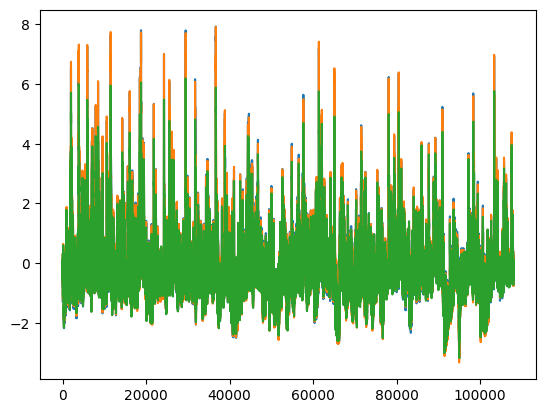

In [84]:
idx_factors = 2

plt.figure()
plt.plot(dd['results']['factors']['scores_final'][idx_factors])
plt.plot(test[idx_factors][:])
plt.plot(test2[idx_factors][:])

In [85]:
test3 = np.nansum(np.einsum('nr, nt -> rnt', weights_remixed, dFoF_aligned[-1]), axis=1)

[[<matplotlib.lines.Line2D at 0x7f6613c3fed0>],

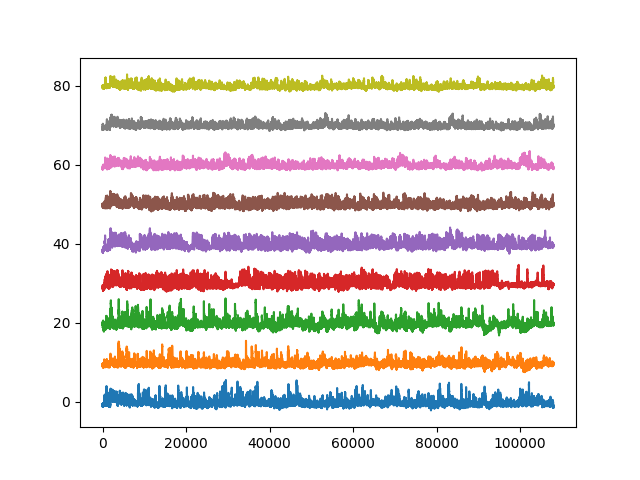

In [91]:
%matplotlib widget
plt.figure()
[plt.plot(np.nansum(np.einsum('nr, nt -> rnt', weights_remixed, dFoF_aligned[ii]), axis=1)[idx_factors] + ii*5) for ii in range(len(dFoF_aligned))]
# plt.ylim([-3,8])

[[<matplotlib.lines.Line2D at 0x7f6b443a8d90>],

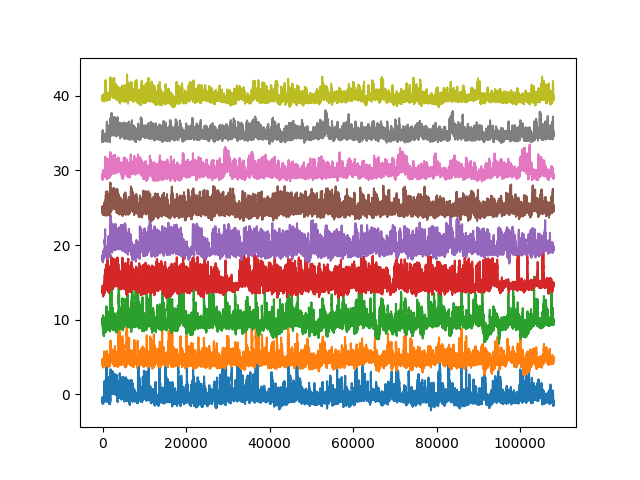

In [92]:
%matplotlib widget
plt.figure()
[plt.plot(np.nansum(np.einsum('nr, nt -> rnt', weights_remixed, dFoF_aligned[ii]), axis=1)[idx_factors] + ii*5) for ii in range(len(dFoF_aligned))]
# plt.ylim([-3,8])

In [108]:
%load_ext autoreload
%autoreload 2
import bmi_idap

import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
device = bnpm.torch_helpers.set_device(use_GPU=True)
Fs = 30

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [225]:
F = torch.nansum(torch.einsum('nr, nts -> rnts', torch.as_tensor(weights_remixed), torch.as_tensor(np.stack(dFoF_aligned, axis=-1))), dim=1)

In [235]:
params = {}
params['simulation'] = {}

params['simulation']['idx_factor'] = 2  ## 0-indexed
params['simulation']['power'] = 2.0
params['simulation']['thresh_reward'] = 1.0
params['simulation']['thresh_quiescence_cursorDecoder'] = 0.1 * params['simulation']['thresh_reward']
params['simulation']['thresh_quiescence_cursorMag'] = 0.1

params['simulation']['duration_quiescence_hold'] = 3
params['simulation']['duration_threshold_hold'] = 3
params['simulation']['win_smooth_cursor'] = 1

In [247]:
decoder = bmi_idap.decoder.Decoder_angle_magnitude(
    F=np.nan_to_num(weights_remixed),
    device=device,
    power=params['simulation']['power'],
)

D, CS, M = decoder(dFoF_aligned[-2])

In [237]:
params['simulation']['thresh_quiescence_cursorMag'] = max([torch.quantile(M[params['simulation']['idx_factor']], q=params['simulation']['thresh_quiescence_cursorMag']).item(), 0])

In [238]:
num_rewards, sm = bmi_idap.decoder.simple_cursor_simulation(
    D.T, 
    CS.T, 
    M.T,
    idx_cursor=params['simulation']['idx_factor'], 
    thresh_reward=params['simulation']['thresh_reward'], 
    thresh_quiescence_cursorMag=params['simulation']['thresh_quiescence_cursorMag'], 
    thresh_quiescence_cursorDecoder=params['simulation']['thresh_quiescence_cursorDecoder'], 
    duration_quiescence_hold=params['simulation']['duration_quiescence_hold'],
    duration_threshold_hold=params['simulation']['duration_threshold_hold'],
    win_smooth_cursor=1,
)

100%|████████████████████████████████| 108000/108000 [00:09<00:00, 11010.12it/s]


In [239]:
rewards_per_min = num_rewards / (D.shape[1] / (Fs*60*1))

print(f"Rewards per minute: {rewards_per_min :.3f}")

Rewards per minute: 1.200


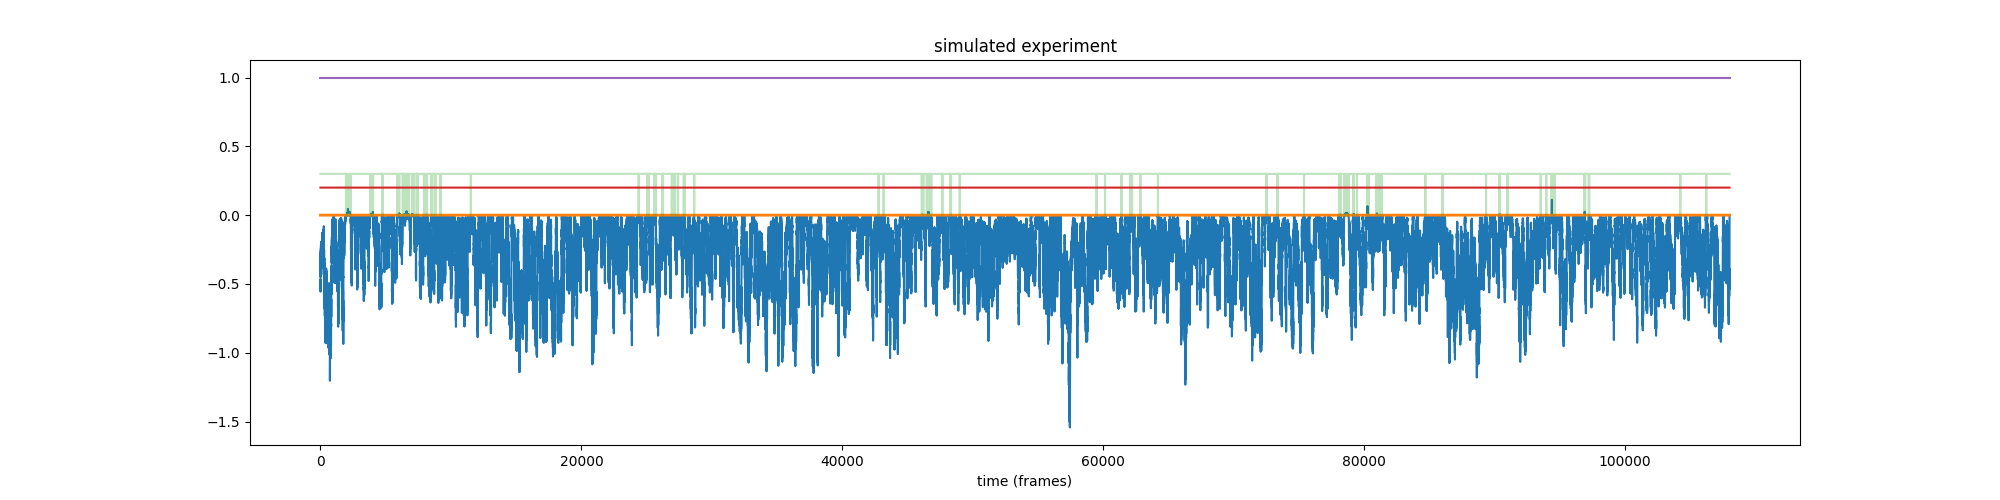

In [231]:
plt.figure(figsize=(20,5))
plt.plot(sm['cursor'])
plt.plot(sm['rewards']*0.5, linewidth=2)
plt.plot(sm['CS_quiescence']*0.3, alpha=0.3)
plt.plot(sm['CE_trial']*0.2)
plt.plot([0, D.shape[1]], [params['simulation']['thresh_reward'], params['simulation']['thresh_reward']])
plt.title('simulated experiment')
plt.xlabel('time (frames)');

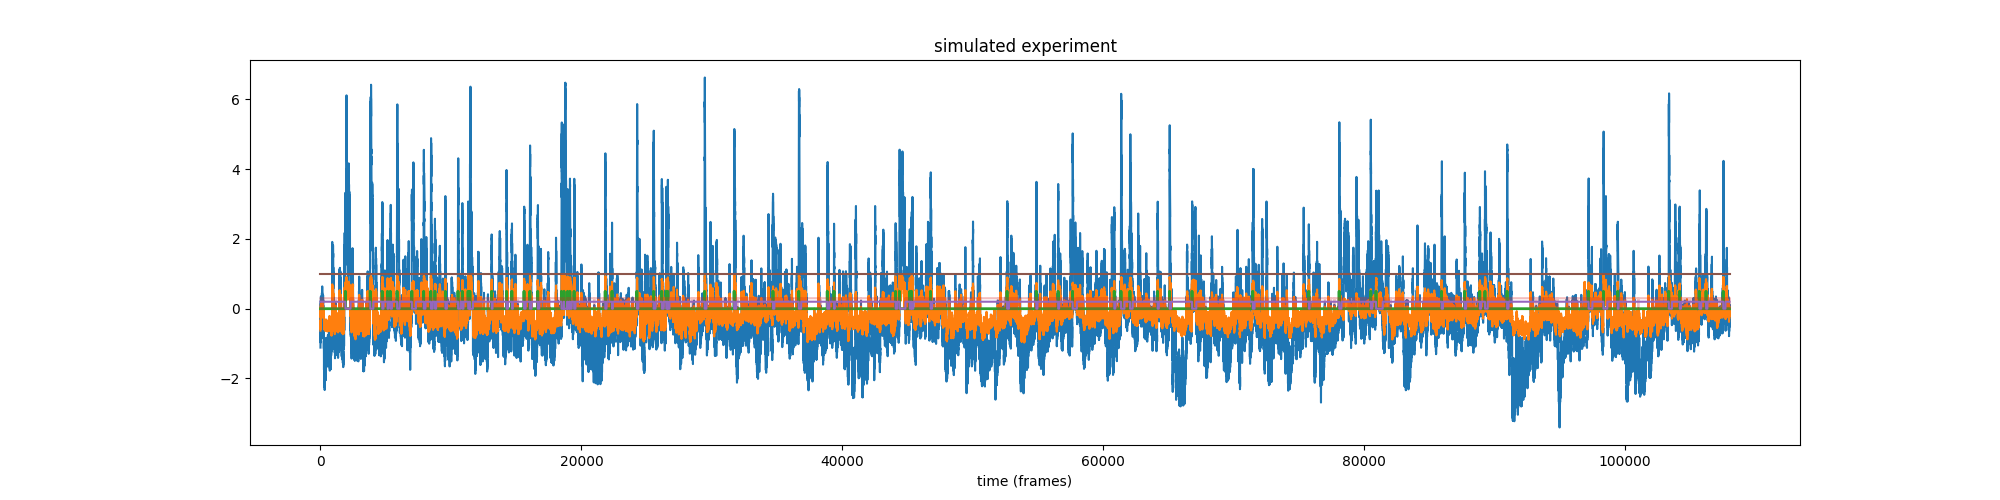

In [163]:
plt.figure(figsize=(20,5))
plt.plot(M[2].cpu())
plt.plot(CS[2].cpu())
plt.plot(sm['rewards']*0.5, linewidth=2)
plt.plot(sm['CS_quiescence']*0.3, alpha=0.3)
plt.plot(sm['CE_trial']*0.2)
plt.plot([0, D.shape[1]], [params['simulation']['thresh_reward'], params['simulation']['thresh_reward']])
plt.title('simulated experiment')
plt.xlabel('time (frames)');

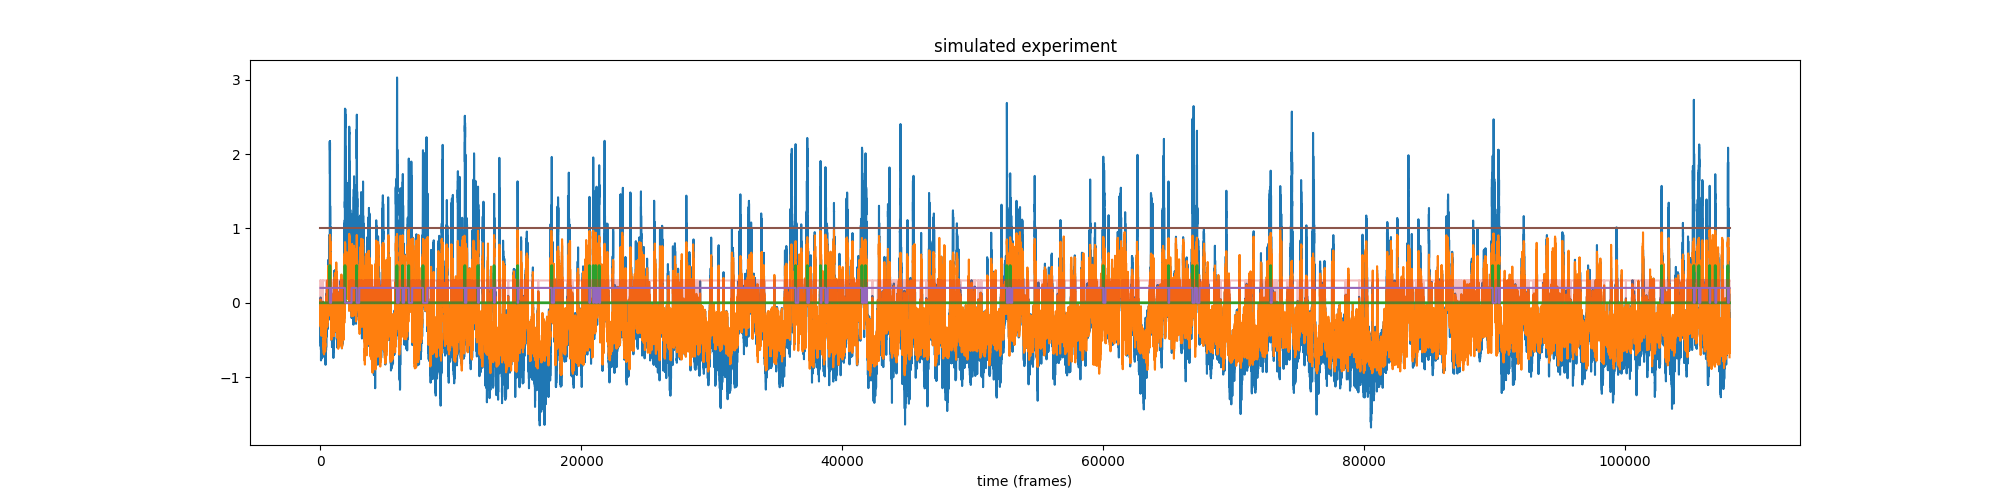

In [158]:
plt.figure(figsize=(20,5))
plt.plot(M[2].cpu())
plt.plot(CS[2].cpu())
plt.plot(sm['rewards']*0.5, linewidth=2)
plt.plot(sm['CS_quiescence']*0.3, alpha=0.3)
plt.plot(sm['CE_trial']*0.2)
plt.plot([0, D.shape[1]], [params['simulation']['thresh_reward'], params['simulation']['thresh_reward']])
plt.title('simulated experiment')
plt.xlabel('time (frames)');

In [208]:
np.argsort([np.nan,1,2,3,np.nan])

array([1, 2, 3, 0, 4])

In [241]:
idx_sorting = np.argsort(weights_remixed, axis=0)

In [176]:
idx_sorting.shape

(890, 6)

In [177]:
dFoF_aligned[2].shape

(890, 108000)

In [178]:
dFoF_aligned[2]

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.6931665 ,  0.7061161 ,  0.7874466 , ...,  0.31125176,
         0.28838506,  0.47032204],
       [-0.15317434,  0.21438693,  0.14502811, ...,  0.17790386,
        -0.0629207 ,  0.27588037],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

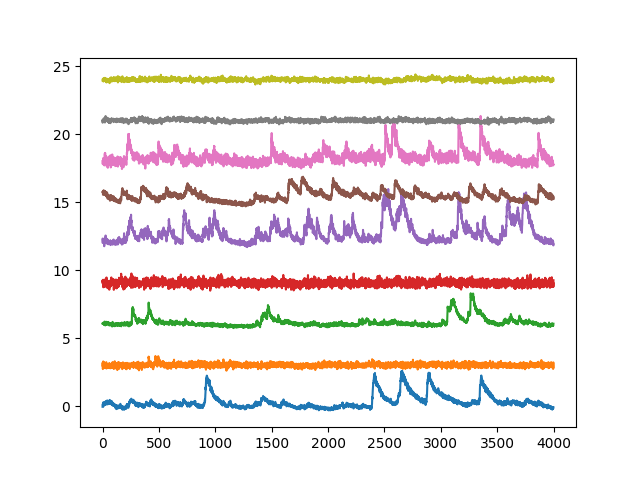

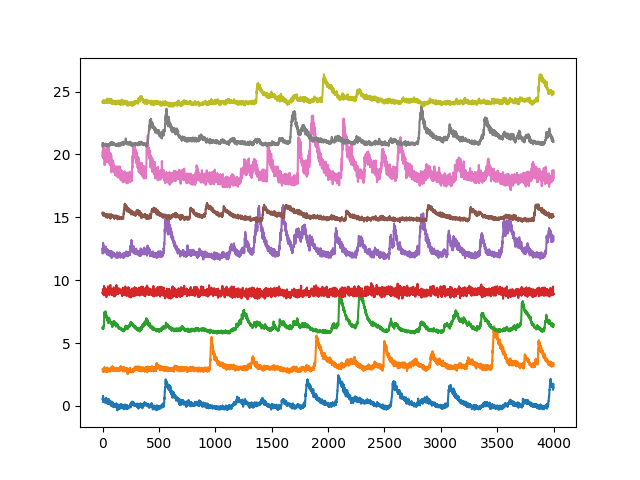

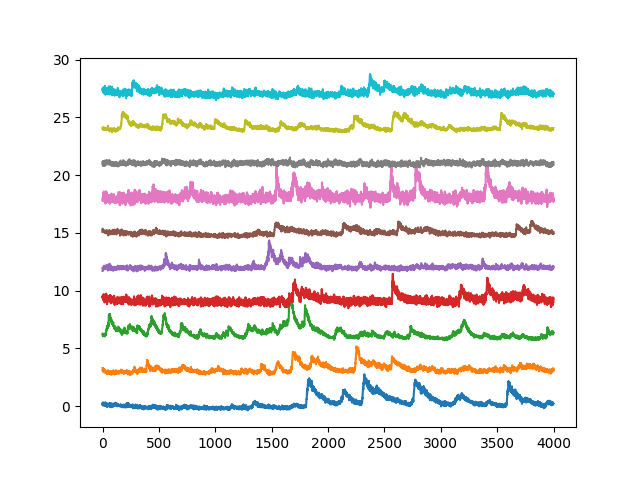

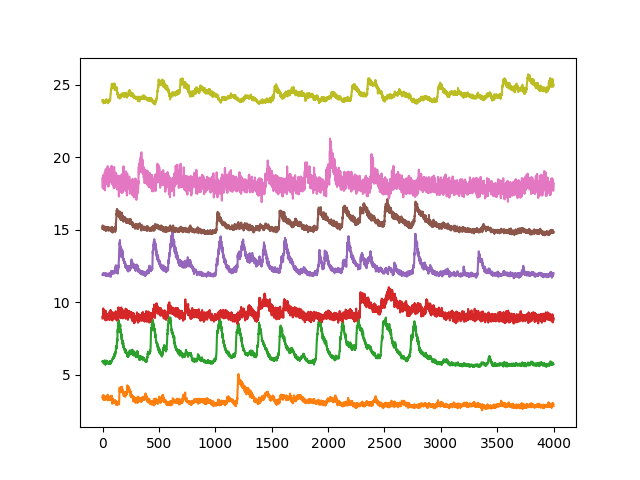

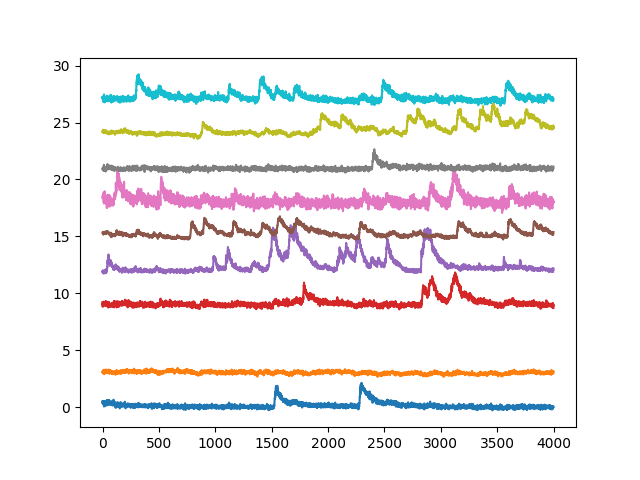

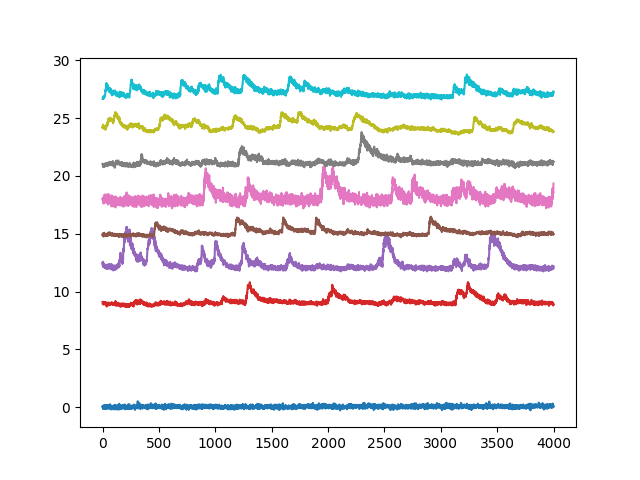

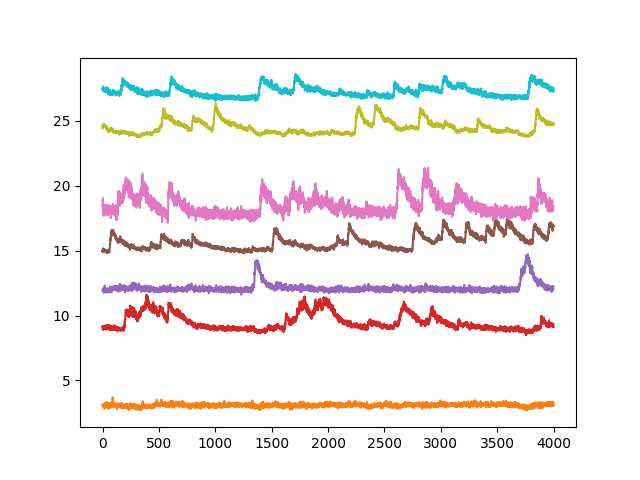

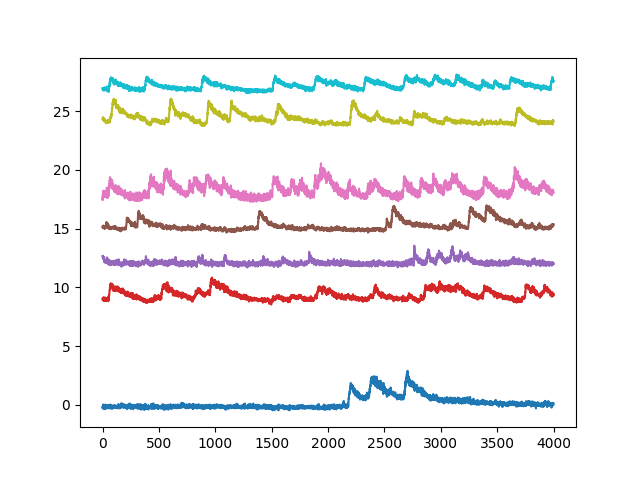

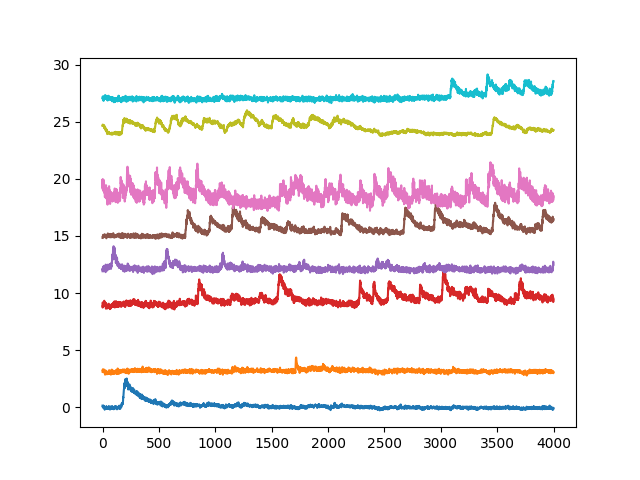

In [254]:
for ii in range(len(dFoF_aligned)):
    plt.figure()
    plt.plot(dFoF_aligned[ii][idx_sorting[:,2]][:10, 10000:14000].T + np.arange(10)[None,:]*3);

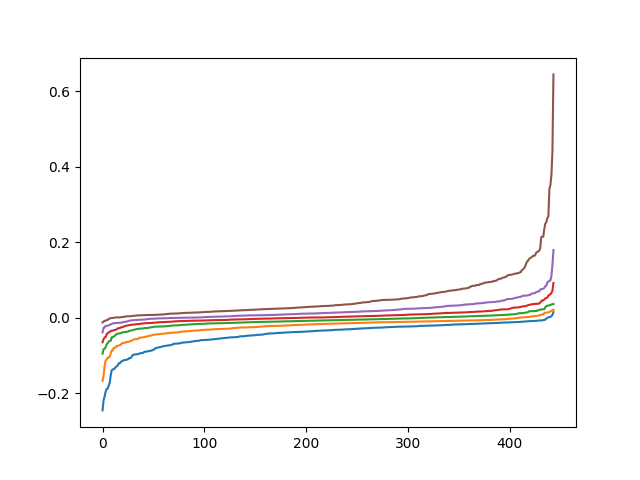

In [204]:
plt.figure()
plt.plot(np.sort(weights_remixed, axis=0))

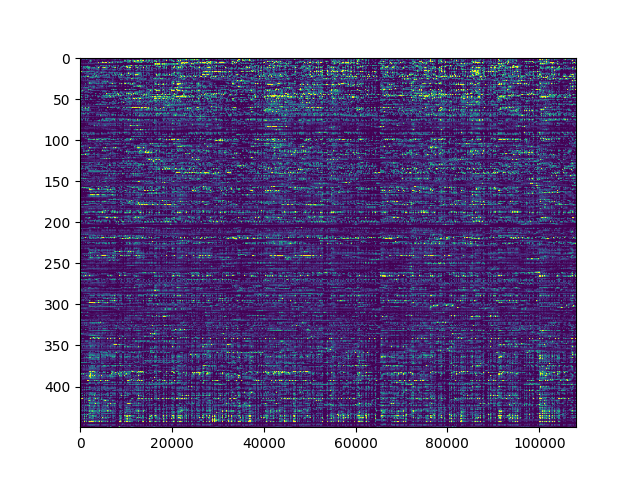

In [220]:
plt.figure()
plt.imshow(np.nan_to_num(dFoF_aligned[0][idx_sorting[:450,2]]), aspect='auto', clim=[0, 1])

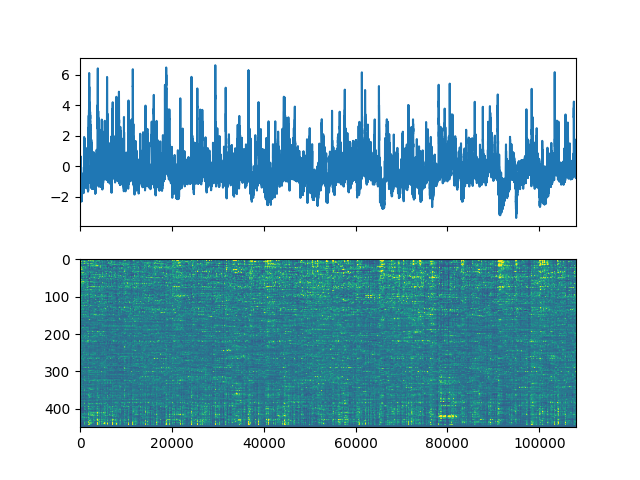

In [246]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(M[2].cpu())
axs[1].imshow(np.nan_to_num(dFoF_aligned[2][idx_sorting[:450,2]]), aspect='auto', clim=[-0.5, 1])

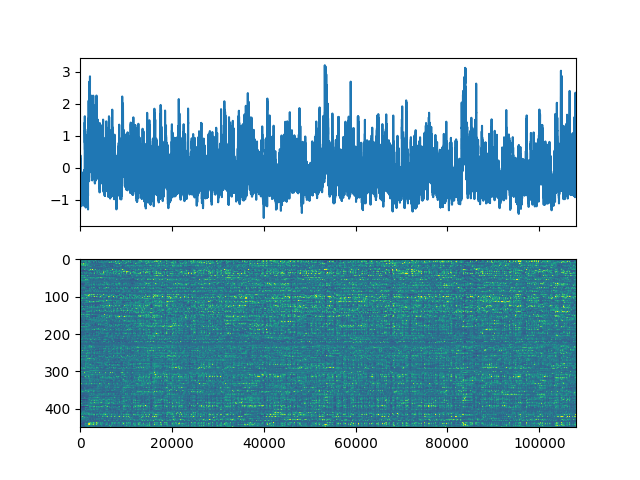

In [249]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(M[2].cpu())
axs[1].imshow(np.nan_to_num(dFoF_aligned[-2][idx_sorting[:450,2]]), aspect='auto', clim=[-0.5, 1])

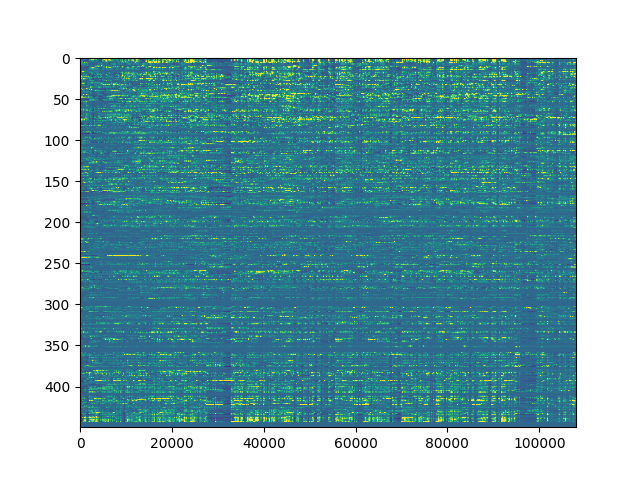

In [244]:
plt.figure()
plt.imshow(np.nan_to_num(dFoF_aligned[3][idx_sorting[:450,2]]), aspect='auto', clim=[-0.5, 1])

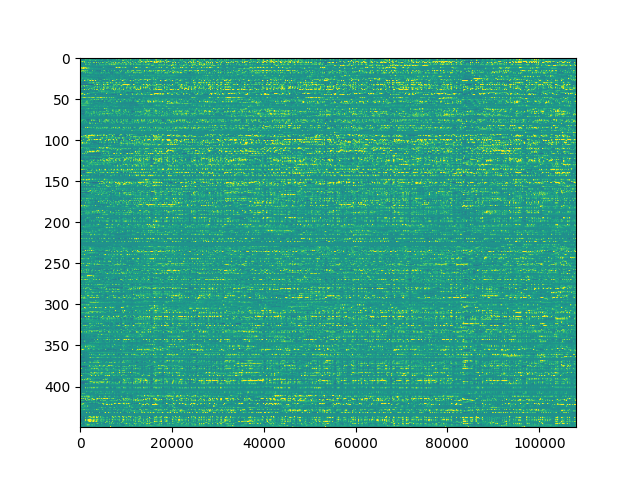

In [245]:
plt.figure()
plt.imshow(np.nan_to_num(dFoF_aligned[-2][idx_sorting[:450,2]]), aspect='auto', clim=[-1, 1])

In [83]:
dFoF_test = roicat.util.match_arrays_with_ucids(
    arrays=list(dFoFs.values())[:2],
    ucids=iscell_decoder['UCIDs_classifier_matching_tqm'],
    squeeze=True,
)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [227]:
test3 = np.nansum(np.einsum('rn, nt -> rnt', dd['results']['factors']['factors_final'], dFoF_test[1]), axis=1)

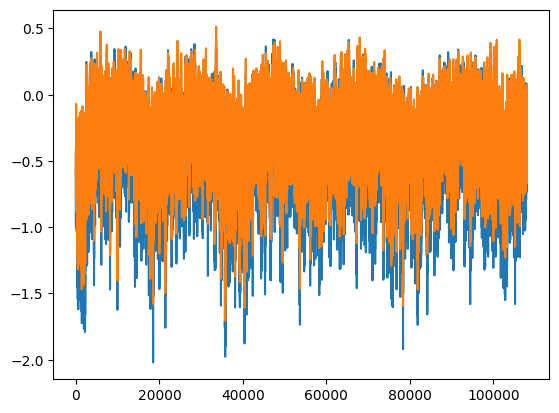

In [225]:
idx_factors = 0

plt.figure()
plt.plot(dd['results']['factors']['scores_final'][idx_factors])
plt.plot(test3[idx_factors])
